In [1]:
import sys
sys.path.append('..') # Search for custom module in the top level. 

# Import my custom modules.
from allens_quantum_package.functions import * 
from allens_quantum_package.operators import *

from qiskit import *
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_experiments.framework import ExperimentData
from qiskit_experiments.library.tomography import MitigatedTomographyAnalysis, MitigatedStateTomography, TomographyAnalysis
from qiskit_experiments.library.tomography.basis import PauliMeasurementBasis
from qiskit_experiments.library.characterization.analysis import LocalReadoutErrorAnalysis
from qiskit_ibm_runtime import QiskitRuntimeService

import scipy
from numpy import set_printoptions, radians, ndarray, pi, degrees, radians
from random import randint
from collections import namedtuple

import itertools
from itertools import product

In [2]:
# Set the floating point diplay precision to 2 decimal places, sufficient for our purposes.
set_printoptions(precision=3)

# Initialise the Qiskit runtime service. 
service = QiskitRuntimeService()

In [2]:
states = [
    (radians(-88), radians(79)),
    (radians(32), radians(-167)),
    (radians(140), radians(125))
]

In [3]:
def build_circuit(theta, phi) -> QuantumCircuit:
    circ = QuantumCircuit(3)

    circ.h(0)
    circ.u(theta, phi, 0, 1)
    circ.cswap(0, 1, 2)

    return circ

In [4]:
def build_tomography_set(circuit: QuantumCircuit) -> QuantumCircuit:
    circuit_x = circuit.copy()
    circuit_x.h([1, 2])
    circuit_x.measure_all()

    circuit_y = circuit.copy()
    circuit_y.sdg([1, 2])
    circuit_y.h([1, 2])
    circuit_y.measure_all()

    circuit_z = circuit.copy()
    circuit_z.measure_all()

    return [circuit_x, circuit_y, circuit_z]


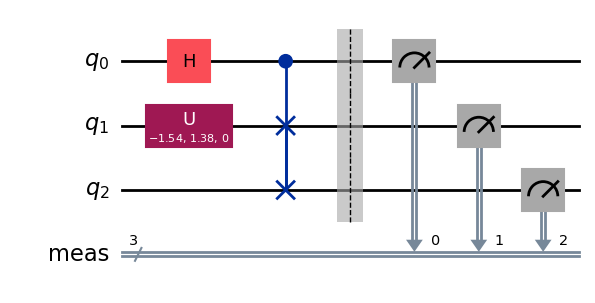

In [6]:
build_tomography_set(build_circuit(*states[0]))[2].draw('mpl')

In [6]:
ibm_brisbane = service.get_backend('ibm_brisbane')

In [7]:
circuits_to_send = list(itertools.chain.from_iterable([
        circuit for circuit in [
            build_tomography_set(build_circuit(theta, phi)) for theta, phi in states
        ]
    ]
))

circuits_to_send = [transpile(circuit, ibm_brisbane) for circuit in circuits_to_send]

In [8]:
def get_all_physical_qubits(circuit_list: list[QuantumCircuit]) -> set[int]:
    all_indices = set()
    for circ in circuit_list:    
        measurement_indices = [instr[1][0]._index for instr in circ.data if instr[0].name == 'measure']
        all_indices = all_indices.union(measurement_indices)
    return all_indices

def get_mitigation_circuits(circuit_list: list[QuantumCircuit]) -> list[QuantumCircuit]:

    physical_qubits = get_all_physical_qubits(circuit_list)

    num_qubits = len(physical_qubits)
    all_0 = QuantumCircuit(127, num_qubits)
    all_0.measure(physical_qubits, range(num_qubits))

    all_1 = QuantumCircuit(127, num_qubits)
    all_1.x(physical_qubits)
    all_1.measure(physical_qubits, range(num_qubits))

    return [all_0, all_1]

In [9]:
circuits_to_send = get_mitigation_circuits(circuits_to_send) + circuits_to_send

In [10]:
hardware_job = ibm_brisbane.run(circuits=circuits_to_send)

In [11]:
print(f"Hardware job ID: {hardware_job.job_id()}")

Hardware job ID: cw6g0f9bhxtg008wbsbg


---

In [18]:
results = hardware_job.result().get_counts()

In [19]:
mem_all_0_counts = results[0]
mem_all_1_counts = results[1]

state_1_counts = (results[2], results[3], results[4])
state_2_counts = (results[5], results[6], results[7])
state_3_counts = (results[8], results[9], results[10])

In [20]:
def bloch_oordinate(counts_dict: dict) -> float:
    if '0' not in counts_dict:
        return -1
    if '1' not in counts_dict:
        return 1
    
    plus = counts_dict['0']
    minus = counts_dict['1']
    return (plus - minus) / (plus + minus)


def density_op_from_bloch_coordinates(rx, ry, rz):

    sqr_norm = rx**2 + ry**2 + rz**2
    if sqr_norm > 1:
        norm = sqrt(sqr_norm)
        rx, ry, rz = rx/norm, ry/norm, rz/norm

    op = array([[1 + rz, rx - 1j*ry],
                [rx + 1j*ry, 1 - rz]])
    
    return 0.5 * op


def density_op_from_counts_dict(counts_x, counts_y, counts_z):
    return density_op_from_bloch_coordinates(
        rx=bloch_oordinate(counts_x),
        ry=bloch_oordinate(counts_y),
        rz=bloch_oordinate(counts_z)
    )

# Filter the correct counts. If q0 is 0, only count q1, if q0 is 1, only count q1.
def process_counts(counts_x: dict, counts_y: dict, counts_z: dict) -> tuple[dict]:
    output_x = {'0': 0, '1': 0}
    output_y = {'0': 0, '1': 0}
    output_z = {'0': 0, '1': 0}

    for input_dict, output_dict in zip((counts_x, counts_y, counts_z), (output_x, output_y, output_z)):
        for bit_string, counts in input_dict.items():
            if bit_string[2] == '0':
                output_dict[bit_string[1]] += counts
            else:
                output_dict[bit_string[0]] += counts
    
    return output_x, output_y, output_z

def print_fidelities(theta, phi, counts_x, counts_y, counts_z):
    counts_x, counts_y, counts_z = process_counts(counts_x, counts_y, counts_z)
    den_op = density_op_from_counts_dict(counts_x, counts_y, counts_z)

    fidelity = state_fidelity(den_op, gen_qubit(theta, phi))
    
    print(f'Unmitigated state fidelity for\ttheta {int(degrees(theta))}°\t phi {int(degrees(phi))}°\t:\t{fidelity}')


In [21]:
for state, counts in zip(states, (state_1_counts, state_2_counts, state_3_counts)):
    print_fidelities(state[0], state[1], counts[0], counts[1], counts[2])

Unmitigated state fidelity for	theta -88°	 phi 79°	:	0.9044445936068506
Unmitigated state fidelity for	theta 32°	 phi -167°	:	0.9223419353465977
Unmitigated state fidelity for	theta 140°	 phi 125°	:	0.9169043079868144


In [ ]:
def get_mitigation_matrix(num_qubits: int, zero_counts: dict[str, int], one_counts: dict[str, int]) -> ndarray:

    assignment_matrices = []
    
    for qubit_idx in range(num_qubits):

        # Determine zero state for assignment matrix
        zero_count = sum([count for result, count in zero_counts.items() if result[qubit_idx] == '0'])
        one_count = sum([count for result, count in zero_counts.items() if result[qubit_idx] == '1'])

        # Calculate zero ket
        zero_ket = array([[zero_count], 
                          [one_count]]) / (zero_count + one_count)
        
        # Determine one state for assignment matrix
        zero_count = sum([count for result, count in one_counts.items() if result[qubit_idx] == '0'])
        one_count = sum([count for result, count in one_counts.items() if result[qubit_idx] == '1'])

        # Calculate one ket
        one_ket = array([[zero_count], 
                         [one_count]]) / (zero_count + one_count)
        
        assignment_matrix = numpy.concatenate([zero_ket, one_ket], axis=1)

        assignment_matrices.append(assignment_matrix)

    return tens(*(scipy.linalg.inv(mat) for mat in assignment_matrices))


def get_bit_strings(count: int) -> list[str]:
    return [''.join(bits) for bits in itertools.product(['0', '1'], repeat=count)]


def mitigate_counts(num_qubits: int, mitigation_matrix: ndarray, counts: dict[str, int]) -> dict[str, int]:
    
    bit_strings = get_bit_strings(num_qubits)

    # Get vector of counts
    counts_vector = numpy.concatenate(
        [array([[counts[bit_string] if bit_string in counts else 0.0]]) for bit_string in bit_strings],
        axis=0
    )

    # Multiply by mitigation matirx
    corrected_vector = mitigation_matrix @ counts_vector
    corrected_vector = corrected_vector.astype(int)

    output = {}
    for idx, bit_string in zip(range(2**num_qubits), bit_strings):
        output[bit_string] = int(corrected_vector[idx])

    return output


def print_mitigated_fidelities(theta, phi, counts_x, counts_y, counts_z, mem_0_counts, mem_1_counts):

    mitigation_matrix = get_mitigation_matrix(3, mem_0_counts, mem_1_counts)

    x_counts_mitigated = mitigate_counts(3, mitigation_matrix, counts_x)
    y_counts_mitigated = mitigate_counts(3, mitigation_matrix, counts_y)
    z_counts_mitigated = mitigate_counts(3, mitigation_matrix, counts_z)    

    x_counts_mitigated, y_counts_mitigated, z_counts_mitigated = process_counts(x_counts_mitigated, y_counts_mitigated, z_counts_mitigated)

    den_op = density_op_from_counts_dict(x_counts_mitigated, y_counts_mitigated, z_counts_mitigated)

    fidelity = state_fidelity(den_op, gen_qubit(theta, phi))

    print(f'Mitigated state fidelity for\ttheta {int(degrees(theta))}°\t phi {int(degrees(phi))}°\t:\t{fidelity}')

In [23]:
for state, counts in zip(states, (state_1_counts, state_2_counts, state_3_counts)):
    print_mitigated_fidelities(state[0], state[1], counts[0], counts[1], counts[2], mem_all_0_counts, mem_all_1_counts)

Mitigated state fidelity for	theta -88°	 phi 79°	:	0.9193003480676969
Mitigated state fidelity for	theta 32°	 phi -167°	:	0.9300554704822767
Mitigated state fidelity for	theta 140°	 phi 125°	:	0.9396119023259795
